# <center> Systematic Trading Strategies with Machine Learning Algorithms </center>

## <center>Programming Session 4 - Introducing Supervised Learning Algorithms for Time Series Forecasting
</center>
<center>
<table class="tfo-notebook-buttons" style="margin-left: auto; margin-right: auto;">
  <tr>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://hm-ai.github.io/Systematic_Trading_Strategies_with_Machine_Learning_Algorithms/">
        <img src="https://drive.google.com/uc?export=view&id=1hTIoxoea8RTLgKb1oE6_PFmtTNPGs5p4" height="50"/>
        <br>Course page
      </a>
    </td>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://colab.research.google.com/drive/1VEmWV7ch6FX_m5Zyq7xjCw_PJXI2Bhtj?usp=sharing">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />
        <br>Run in Google Colab
      </a>
    </td>
  </tr>
</table>
</center>

---
* This programming session focuses on building and evaluating supervised learning models to forecast daily COVID-19 deaths.
* We begin by **preprocessing the dataset**, which includes feature scaling and preparation of train-test splits suitable for time series forecasting.
* We implement **tree-based models**, starting with:

  * **XGBoost**, a powerful gradient boosting algorithm optimized for performance and speed.
  * **Random Forest**, an ensemble of decision trees known for its robustness and ability to reduce overfitting.
* We then move on to **neural networks**, implementing:

  * **A basic feedforward neural network** with two hidden layers to establish a simple deep learning baseline.
  * **An enhanced neural network** that includes batch normalization and dropout for improved generalization and stability during training.
* The final section is **performance analysis**, where we:

  * Evaluate all models using metrics such as MAE, MSE, RMSE, MAPE, and R².
  * Perform **feature importance analysis** for the tree-based models using impurity-based scores.
  * **Compare model performance**.
  * **Visualize predictions** from all models in a single plot to assess their behavior and alignment with actual values.

---



In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Machine learning libraries
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance

# Neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
import random
import os
import tensorflow as tf

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
# Helper function for calculating MAPE safely
def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error safely handling zeros and conversions

    Args:
        y_true: Actual values
        y_pred: Predicted values

    Returns:
        mape: Mean Absolute Percentage Error
    """
    # Convert to numpy arrays if they are pandas Series
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    # Flatten predictions if they are 2D
    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()

    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Function to calculate and report comprehensive metrics
def calculate_metrics(y_true, y_pred, model_name):
    """
    Calculate and return comprehensive performance metrics

    Args:
        y_true: Actual values
        y_pred: Predicted values
        model_name: Name of the model

    Returns:
        metrics_dict: Dictionary containing all metrics
    """
    # Handle different input types
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = calculate_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Create metrics dictionary
    metrics_dict = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R²': r2
    }

    return metrics_dict

def report_metrics(metrics_dict):
    """
    Print formatted metrics report

    Args:
        metrics_dict: Dictionary containing metrics
    """
    print(f"\n{metrics_dict['Model']} Results:")
    print(f"  MAE: {metrics_dict['MAE']:.2f}")
    print(f"  MSE: {metrics_dict['MSE']:.2f}")
    print(f"  RMSE: {metrics_dict['RMSE']:.2f}")
    print(f"  MAPE: {metrics_dict['MAPE (%)']:.2f}%")
    print(f"  R²: {metrics_dict['R²']:.4f}")


# Preprocessing the Dataset

In [ ]:
# Load COVID-19 deaths data from the provided URL
url = 'https://drive.google.com/uc?id=1KvRu9XjaAZT8qHK1DO5OfHkfS9TWoZnv'


# Load data from URL
print(f"Loading data from URL...")
deaths_df = pd.read_csv(url)

Loading data from URL...


In [ ]:
# Display basic information about the dataset
print(f"Dataset shape: {deaths_df.shape}")
print(f"First few columns: {deaths_df.columns}...")

Dataset shape: (266, 212)
First few columns: Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '8/7/20', '8/8/20', '8/9/20', '8/10/20', '8/11/20', '8/12/20',
       '8/13/20', '8/14/20', '8/15/20', '8/16/20'],
      dtype='object', length=212)...


In [ ]:
# Extract date columns (all columns after the first 4)
date_cols = deaths_df.columns[4:]
print(f"\nTime range: {date_cols[0]} to {date_cols[-1]}")
print(f"Number of days: {len(date_cols)}")


Time range: 1/22/20 to 8/16/20
Number of days: 208


In [ ]:
# Process global death counts by summing across all countries/regions
d = deaths_df.loc[:, date_cols]  # Select only date columns
d = d.transpose()                # Transpose to have dates as rows
d = d.sum(axis=1)                # Sum across all countries/regions
d = d.to_list()                  # Convert to list

# Create a proper time series DataFrame
dataset = pd.DataFrame(columns=['ds', 'y'])
dates = list(pd.to_datetime(date_cols))  # Convert string dates to datetime
dataset['ds'] = dates
dataset['y'] = d
dataset = dataset.set_index('ds')         # Set dates as index

In [ ]:
# Calculate daily deaths (first derivative)
daily_deaths = dataset.diff()
daily_deaths = daily_deaths.dropna()  # Drop NaN values from differencing

# Apply 4-day rolling average to smooth out reporting irregularities
daily_deaths_smoothed = daily_deaths.rolling(window=4, center=True).mean()
daily_deaths_smoothed = daily_deaths_smoothed.fillna(daily_deaths)

# Use the smoothed version for our analysis
dataset = daily_deaths_smoothed

In [ ]:
# Split data into training and testing sets
start_date = '2020-07-31'
train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

# Display training and testing set information
print(f"\nTraining set: {train.shape[0]} days from {train.index.min().date()} to {train.index.max().date()}")
print(f"Testing set: {test.shape[0]} days from {test.index.min().date()} to {test.index.max().date()}")


Training set: 190 days from 2020-01-23 to 2020-07-30
Testing set: 17 days from 2020-07-31 to 2020-08-16


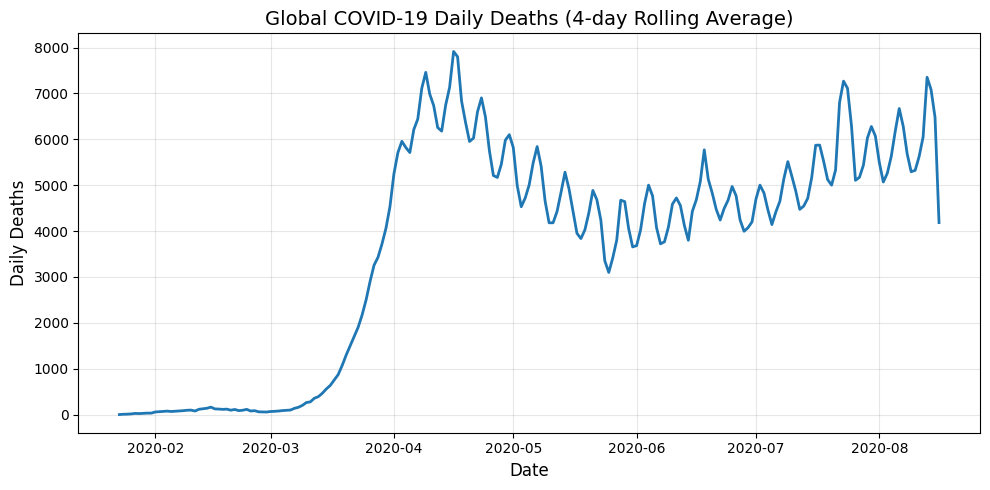

In [ ]:
# Visualize daily deaths
plt.figure(figsize=(10, 5))
plt.plot(dataset, linewidth=2, color='#1f77b4')
plt.title('Global COVID-19 Daily Deaths (4-day Rolling Average)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Deaths', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Daily_deaths.png', bbox_inches='tight')
plt.show()

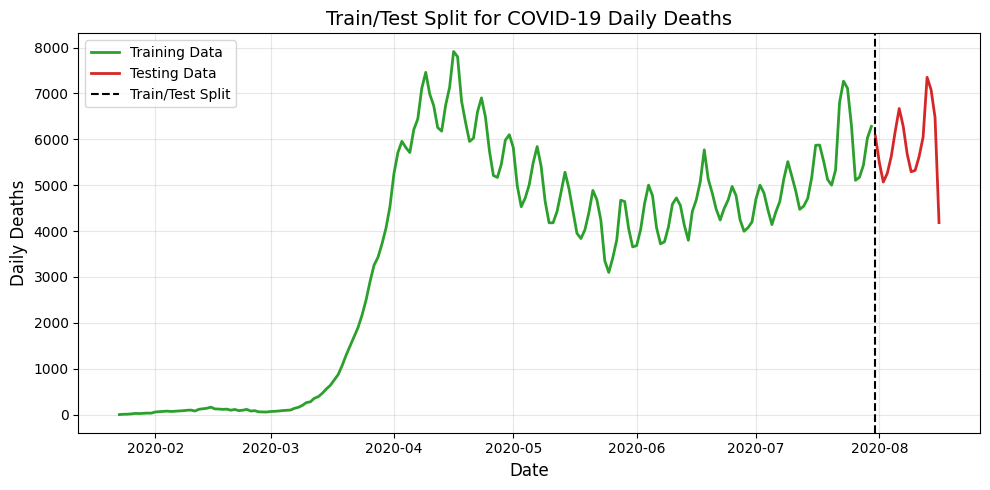

In [ ]:
# Visualize train/test split
plt.figure(figsize=(10, 5))
plt.plot(train, label='Training Data', linewidth=2, color='#2ca02c')
plt.plot(test, label='Testing Data', linewidth=2, color='#d62728')
plt.axvline(pd.to_datetime(start_date), color='black', linestyle='--', linewidth=1.5, label='Train/Test Split')
plt.title('Train/Test Split for COVID-19 Daily Deaths', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Deaths', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Train_test_split.png', bbox_inches='tight')
plt.show()

In [ ]:
# Function to engineer features for time series
def featurize(t):
    """
    Create time-based features from datetime index

    Args:
        t: DataFrame with datetime index and 'y' column

    Returns:
        X: DataFrame with engineered features
        y: Series with target values
    """
    X = pd.DataFrame(index=t.index)

    # Calendar features
    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.isocalendar().week

    # Add more features for better model performance
    X['is_weekend'] = (t.index.dayofweek >= 5).astype(int)

    # Cyclical encoding of time features
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['day_sin'] = np.sin(2 * np.pi * X['day'] / 31)
    X['day_cos'] = np.cos(2 * np.pi * X['day'] / 31)
    X['dayofweek_sin'] = np.sin(2 * np.pi * X['dayofweek'] / 7)
    X['dayofweek_cos'] = np.cos(2 * np.pi * X['dayofweek'] / 7)

    # Days since start of time series (trend feature)
    X['days_since_start'] = (t.index - t.index.min()).days

    # Add lag features (past values)
    for lag in [1, 3, 7, 14]:  # 1, 3, 7, and 14 day lags
        X[f'lag_{lag}'] = t['y'].shift(lag)

    # Add rolling statistics
    for window in [7, 14]:
        X[f'rolling_mean_{window}'] = t['y'].rolling(window=window).mean().shift(1)
        X[f'rolling_std_{window}'] = t['y'].rolling(window=window).std().shift(1)

    # Fill NaN values that result from lagging
    X = X.fillna(method='bfill')

    # Extract target variable
    y = t['y']

    return X, y

---

<font color=green>Q1:</font> <font color='green'>
Given the training set `train` and the test set `test`, and the `featurize` function that returns a feature matrix `X` and target vector `y`:

1. Apply `featurize` to both `train` and `test` to obtain `X_train, y_train, X_test, y_test`.
2. Use scikit-learn’s `StandardScaler` to fit on `X_train` and transform both `X_train` and `X_test` into scaled arrays?
</font>  

---

In [ ]:
# Prepare training and testing data
#### YOUR CODE HERE ####

print(f"\nFeature engineering complete:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Features: {', '.join(X_train.columns[:5])} ... and {len(X_train.columns)-5} more")

# Scale features for machine learning models
#### YOUR CODE HERE ####


Feature engineering complete:
X_train shape: (190, 22)
X_test shape: (17, 22)
Features: day, month, quarter, dayofweek, dayofyear ... and 17 more


# Tree based Models

### XGboost Model

---

<font color=green>Q2:</font> <br><font color='green'>
Instantiate an XGBoost regression model with 100 estimators, a learning rate of 0.1, and a maximum depth of 5. Use a predefined random seed for reproducibility. Train the model on the training data, evaluate it on both the training and test sets, and make predictions on the test set. Finally, calculate and report the regression metrics using the provided `calculate_metrics` and `report_metrics` functions.
</font>

---


In [ ]:
# Instantiate the Xgboost model
#### YOUR CODE HERE ####

# Train the model
#### YOUR CODE HERE ####

# Make predictions
#### YOUR CODE HERE ####

# Calculate metrics
#### YOUR CODE HERE ####


XGBoost Results:
  MAE: 323.81
  MSE: 305644.69
  RMSE: 552.85
  MAPE: 6.13%
  R²: 0.4699


---

<font color=green>Q3:</font> <br><font color='green'>
Plot the actual versus predicted daily deaths. Display the test set dates on the x-axis, and compare the true values to the XGBoost predictions.
</font>

---


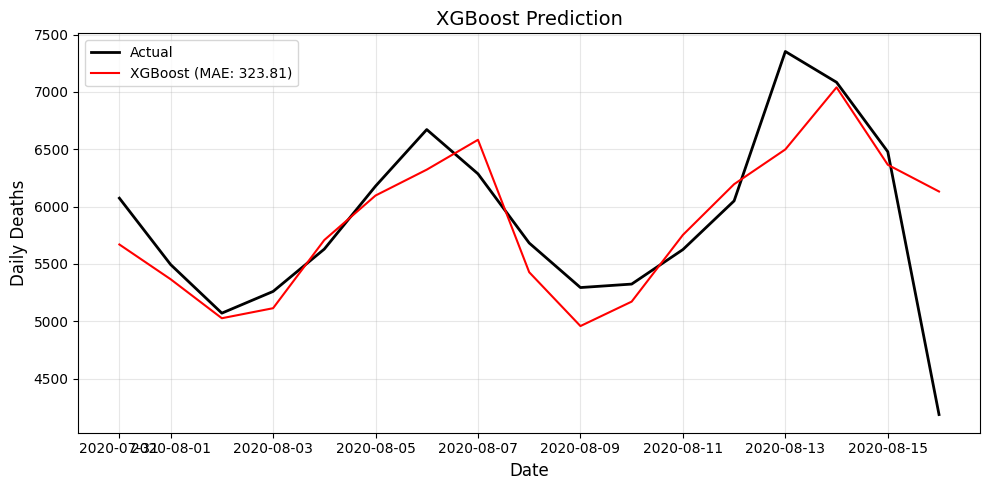

In [ ]:
# Plot predictions
plt.figure(figsize=(10, 5))
#### YOUR CODE HERE ####
plt.title('XGBoost Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Deaths', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Ranfom Forest Model

---

<font color=green>Q4:</font> <br><font color='green'>
* Define a parameter grid for a `RandomForestRegressor`, including:
  * `n_estimators`: \[50, 100, 200, 300]
  * `max_depth`: \[None, 10, 20, 30]
  * `min_samples_split`: \[2, 5, 10]
  * `min_samples_leaf`: \[1, 2, 4]
  * `max_features`: \['auto', 'sqrt', 'log2']
  * `bootstrap`: \[True, False]
* Create a `TimeSeriesSplit` cross-validation strategy with 5 splits.
* Use `RandomizedSearchCV` to perform hyperparameter tuning with:
  * The above parameter grid
  * 20 iterations
  * Negative mean absolute error as the scoring metric
  * Parallel processing (`n_jobs=-1`)
  * A fixed random seed for reproducibility
* Fit the randomized search on the scaled training data.
* Print the best hyperparameters found by the search.
</font>

---


In [ ]:
# Define parameter grid for Random Forest
#### YOUR CODE HERE ####

# Create time series cross-validation strategy
#### YOUR CODE HERE ####

# Use RandomizedSearchCV for Random Forest
#### YOUR CODE HERE ####

# Fit the random search
#### YOUR CODE HERE ####


# Get the best parameters
#### YOUR CODE HERE ####


Best Random Forest Parameters:
  n_estimators: 50
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: 20
  bootstrap: False


---

<font color=green>Q5:</font> <br><font color='green'>
* Instantiate a `RandomForestRegressor` using the best hyperparameters obtained from the previous `RandomizedSearchCV` run.
* Set the random seed for reproducibility using `random_state`.
* Train the model on the scaled training data.
</font>

---


In [ ]:
# Train Random Forest with best parameters
#### YOUR CODE HERE ####

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                      n_estimators=50, random_state=42)

---

<font color=green>Q6:</font> <br><font color='green'>
* Use the trained `RandomForestRegressor` model to make predictions on the scaled test data.
* Store the predictions in a variable.
</font>

---


In [ ]:
# Make predictions
#### YOUR CODE HERE ####

---
<font color=green>Q7:</font> <br><font color='green'>
* Evaluate the predictions from the `RandomForestRegressor` model by computing performance metrics using the `calculate_metrics` function.
* Display the results using the `report_metrics` function.
</font>

---


In [ ]:
# Calculate metrics
#### YOUR CODE HERE ####


Random Forest Results:
  MAE: 470.32
  MSE: 434834.96
  RMSE: 659.42
  MAPE: 7.96%
  R²: 0.2458


---
<font color=green>Q8:</font> <br><font color='green'>
Plot the actual versus predicted daily deaths
</font>

---


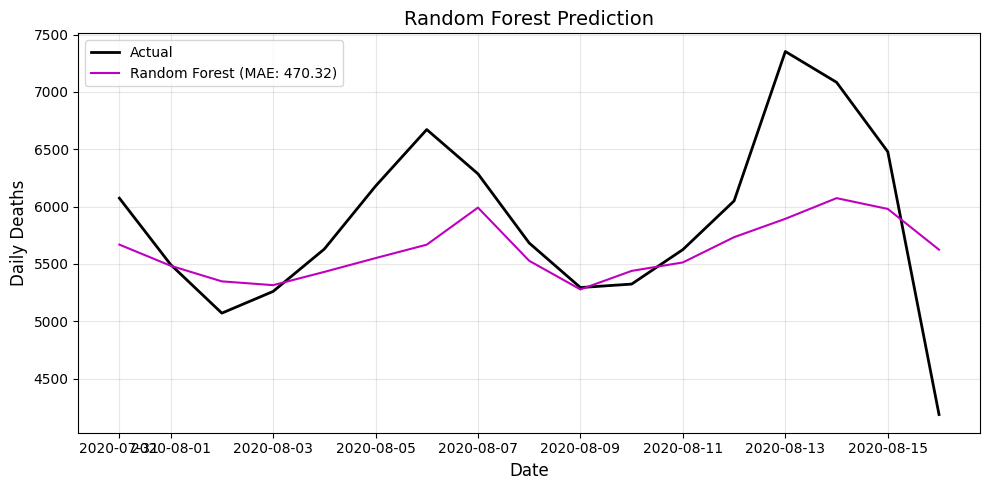

In [ ]:
# Plot Random Forest results
plt.figure(figsize=(10, 5))
#### YOUR CODE HERE ####
plt.title('Random Forest Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Deaths', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Random_Forest_prediction.png', bbox_inches='tight')
plt.show()

# Neural Networks

### A basic Neural Networks

Here is the corresponding question in markdown format with bullet points:

---
<font color=green>Q9:</font> <br><font color='green'>
* Build a basic feedforward neural network using Keras with the following architecture:
  * Input layer matching the number of features
  * First hidden layer: 32 units, ReLU activation
  * Second hidden layer: 16 units, ReLU activation
  * Output layer: 1 unit (no activation)
* Compile the model with:
  * Loss function: Mean Absolute Error (`'mean_absolute_error'`)
  * Optimizer: Adam with a learning rate of 0.001
* Define an early stopping callback that:
  * Monitors validation loss
  * Has a patience of 20 epochs
  * Restores the best weights
  * Suppresses verbose output
* Train the model for up to 200 epochs with:
  * Batch size of 16
  * Validation on the test set
  * No training output (`verbose=0`)
  * The early stopping callback included
</font>

---


In [ ]:
# Build model
#### YOUR CODE HERE ####

# Compile model
#### YOUR CODE HERE ####

# Add callbacks for better training
#### YOUR CODE HERE ####

# Train the model
#### YOUR CODE HERE ####

---
<font color=green>Q10:</font> <br><font color='green'>
* Use the trained basic neural network model to make predictions on the scaled test data.
* Evaluate the predictions by computing performance metrics with `calculate_metrics`, using `"Basic Neural Network"` as the model name.
* Display the results using `report_metrics`.
* Plot actual vs predicted daily deaths:
</font>

---


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Basic Neural Network Results:
  MAE: 533.61
  MSE: 586135.76
  RMSE: 765.60
  MAPE: 9.70%
  R²: -0.0166


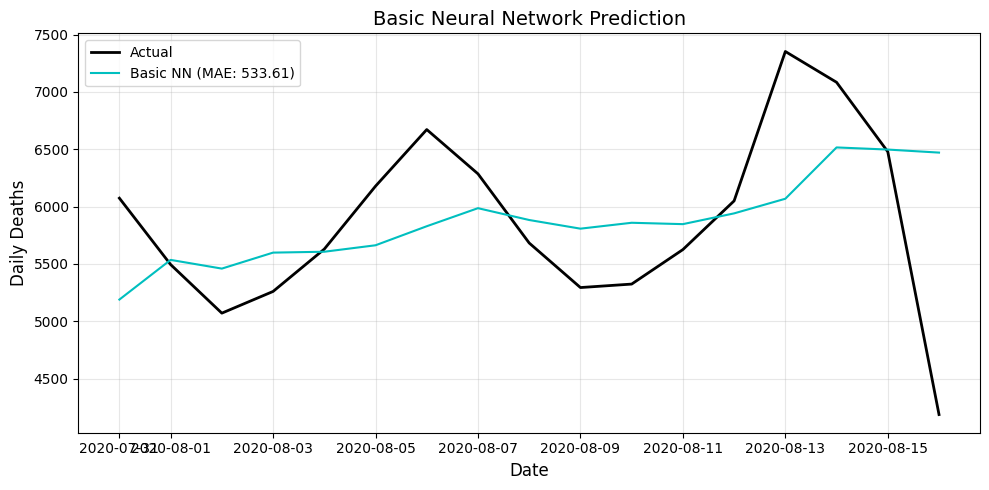

In [ ]:
# Make predictions
#### YOUR CODE HERE ####

# Calculate metrics
#### YOUR CODE HERE ####

# Plot Basic Neural Network results
plt.figure(figsize=(10, 5))
#### YOUR CODE HERE ####
plt.title('Basic Neural Network Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Deaths', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Basic_NN_prediction.png', bbox_inches='tight')
plt.show()

### Enhanced Neural Networks

Here is the compact version of Q11 in the required markdown format:

---
<font color=green>Q11:</font> <br><font color='green'>
* Build an enhanced feedforward neural network using Keras with the following architecture:
  * Input layer matching the number of features
  * Dense layer with 64 units and ReLU activation
  * Batch normalization
  * Dropout with a rate of 0.2
  * Dense layer with 32 units and ReLU activation
  * Batch normalization
  * Dropout with a rate of 0.2
  * Dense layer with 16 units and ReLU activation
  * Output layer with 1 unit
* Compile the model using:
  * Mean Absolute Error loss
  * Adam optimizer with a learning rate of 0.001
* Define the following callbacks:
  * `EarlyStopping` (same as previously defined)
  * `ReduceLROnPlateau` to reduce learning rate: monitor validation loss, factor 0.5, patience 5, min\_lr 0.0001
* Train the model with:
  * Up to 200 epochs
  * Batch size of 16
  * Validation on the test set
  * Silent output (`verbose=0`)
  * Both callbacks enabled
* Make predictions on the scaled test data
* Evaluate and report model performance using `calculate_metrics` and `report_metrics` with the name `"Enhanced Neural Network"`
* Show training and validation loss over epochs
</font>

---


In [ ]:
# Build enhanced model
#### YOUR CODE HERE ####

# Compile model
#### YOUR CODE HERE ####

# Additional callbacks
#### YOUR CODE HERE ####

# Train the model
#### YOUR CODE HERE ####

# Make predictions
#### YOUR CODE HERE ####

# Calculate metrics
#### YOUR CODE HERE ####



# Plot training history
#### YOUR CODE HERE ####

---
<font color=green>Q12:</font> <br><font color='green'>
Plot the actual versus predicted daily deaths for the enhanced neural network model
</font>

---


In [ ]:
# Plot Enhanced Neural Network results
plt.figure(figsize=(10, 5))
#### YOUR CODE HERE ####
plt.title('Enhanced Neural Network Prediction', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Deaths', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Enhanced_NN_prediction.png', bbox_inches='tight')
plt.show()

# Performance Analysis

### Feature Importance Analysis

---
<font color=green>Q13:</font> <br><font color='green'>
* Extract feature importances from the trained XGBoost model using the `.feature_importances_` attribute
* Create a DataFrame with feature names and their corresponding importance scores
* Sort the DataFrame in descending order of importance
* Plot the top 15 features using a horizontal bar plot with Seaborn
</font>

---


In [ ]:
# XGBoost Feature Importance (MDI - Mean Decrease in Impurity)
print("Analyzing XGBoost Feature Importance...")
#### YOUR CODE HERE ####
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importance
})
xgb_importance_df = xgb_importance_df.sort_values('Importance', ascending=False)

# Plot XGBoost feature importance
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=#### YOUR CODE HERE ####,
    palette='viridis'
)
plt.title('XGBoost Feature Importance (MDI)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', bbox_inches='tight')
plt.show()

---
<font color=green>Q14:</font> <br><font color='green'>
* Extract feature importances from the trained Random Forest model using the `.feature_importances_` attribute
* Create a DataFrame with feature names and their corresponding importance scores
* Sort the DataFrame in descending order of importance
* Plot the top 15 features using a horizontal bar plot with Seaborn
</font>

---


In [ ]:
# Random Forest Feature Importance
print("\nAnalyzing Random Forest Feature Importance...")
#### YOUR CODE HERE ####
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importance
})
rf_importance_df = rf_importance_df.sort_values('Importance', ascending=False)

# Plot Random Forest feature importance
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=#### YOUR CODE HERE ####,
    palette='mako'
)
plt.title('Random Forest Feature Importance', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('random_forest_feature_importance.png', bbox_inches='tight')
plt.show()

### Model Performance Comparison

---
<font color=green>Q15:</font> <br><font color='green'>
* Create a DataFrame to compare the performance of all trained models: XGBoost, Random Forest, Basic Neural Network, and Enhanced Neural Network
* Include the following evaluation metrics for each model: MAE, MSE, RMSE, MAPE (%), and R²
* Sort the DataFrame by MAE in ascending order
* Print the sorted comparison table
</font>

---


In [ ]:
# Create a DataFrame with all model results
#### YOUR CODE HERE ####

### Plot all model predictions together

---
<font color=green>Q16:</font> <br><font color='green'>
Plot actual values and predictions from all models in a single figure with legends showing each model’s MAE.
</font>

---


In [ ]:
# Create a DataFrame with all predictions aligned by date
#### YOUR CODE HERE ####

# Add predictions from each model
#### YOUR CODE HERE ####

# Plot all predictions
plt.figure(figsize=(10, 5))

# Plot actual
plt.plot(
    predictions_df['Actual'],
    'k-',
    label='Actual',
    linewidth=2.5,
    zorder=10  # Put actual line on top
)

# Define colors for models
colors = {
    'XGBoost': '#d62728',
    'Random Forest': '#9467bd',
    'Basic NN': '#8c564b',
    'Enhanced NN': '#e377c2'
}

# Plot each model's predictions
for model in predictions_df.columns[1:]:
    # Get metrics for this model
    if model == 'XGBoost': metrics = xgb_metrics
    elif model == 'Random Forest': metrics = rf_metrics
    elif model == 'Basic NN': metrics = basic_nn_metrics
    elif model == 'Enhanced NN': metrics = enhanced_nn_metrics

    # Plot with model name and MAE in legend
    plt.plot(
        predictions_df[model],
        color=colors[model],
        label=f'{model} (MAE: {metrics["MAE"]:.2f})',
        linewidth=1.8,
        alpha=0.7,
        linestyle='-'
    )

# Add title and labels
plt.title('COVID-19 Daily Deaths Prediction - Model Comparison', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Deaths', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Contact

If you have any question regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk